In [3]:
# These libraries are available in the Python 3 kernel
import pandas as pd
import numpy as np
import dill
import random
import math

# These libraries are not available in the Python 3 kernel but are in py-gordon_2_0_0
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor

np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Collect simulation data sets

## Lists of parameters

In [4]:
# These are the outputs that we have available in the simulation files
variable_names = {
        "dust" : "atmosphere_optical_thickness_due_to_dust_ambient_aerosol",
        "soluble_aitken_mode" : "atmosphere_optical_thickness_due_to_soluble_aitken_mode_ambient_aerosol",
        "soluble_accumulation_mode" : "atmosphere_optical_thickness_due_to_soluble_accumulation_mode_ambient_aerosol",
        "soluble_coarse_mode" : "atmosphere_optical_thickness_due_to_soluble_coarse_mode_ambient_aerosol",
        "insoluble_aitken_mode" : "atmosphere_optical_thickness_due_to_insoluble_aitken_mode_ambient_aerosol",
        "insoluble_accumulation_mode" : "atmosphere_optical_thickness_due_to_insoluble_accumulation_mode_ambient_aerosol",
        "insoluble_coarse_mode" : "atmosphere_optical_thickness_due_to_insoluble_coarse_mode_ambient_aerosol"
}

# An array of strings "0801", "0802", ..., "0929", "0930"
dates = ["0" + str(int("0801") + k*int("0001"))
         for k in range(0, 31)] + ["0" + str(int("0901") + k*int("0001"))
                                   for k in range(0, 30)]

# Times of day in 3-hour increments, the level at which the high resolution simulations were averaged
# Of the form 'HA' or 'HP', where 'H' is the hour (a multiple of 3) and 'A' or 'P' designates AM or PM
times = ['3A', '6A', '9A', '12P', '3P', '6P', '9P', '12A']

# An array of strings "000", "001", ..., "219", "220"
ensemble = ["0"*(3-len(str(int("000") + k*int("001")))) + str(int("000") + k*int("001")) for k in range(0, 221)]

# A comma-separated table of simulation ensemble members' parameter combinations
csv_table_metric = c3.SimulationModelParameters.fetch().objs.toJson()

# Save this table instead as a pandas dataframe (221 ensemble members x 64 parameters)
dfparams = pd.DataFrame(csv_table_metric)
dfparams["member"] = dfparams.id.str.split('_', 3, expand=True)[3].apply(lambda x: x.zfill(3))
dfparams_of_interest = dfparams.iloc[:, 5:65]

This is what the range of the parameter space is.

In [5]:
parameter_space = pd.concat([dfparams.iloc[:, 5:59].max(), dfparams.iloc[:, 5:59].min()], axis=1)
print(parameter_space)

negligible_inputs = ['acure_carb_ff_ems',
                     'acure_carb_bb_ems',
                     'acure_carb_res_ems',
                     'acure_anth_so2']
interesting_inputs = list(set(list(dfparams_of_interest.columns[0:59])).difference(set(negligible_inputs)))

                                          0         1
acure_bl_nuc                       0.999897  0.000885
acure_ait_width                    0.999060  0.007782
acure_cloud_ph                     0.998941  0.000192
acure_carb_ff_ems                  1.000000  1.000000
acure_carb_ff_ems_eur              0.999110  0.002116
acure_carb_ff_ems_nam              0.997953  0.007129
acure_carb_ff_ems_chi              0.997967  0.002098
acure_carb_ff_ems_asi              0.994552  0.001652
acure_carb_ff_ems_mar              0.988573  0.002346
acure_carb_ff_ems_r                0.999334  0.000980
acure_carb_bb_ems                  1.000000  1.000000
acure_carb_bb_ems_sam              0.996482  0.000317
acure_carb_bb_ems_naf              0.995887  0.002032
acure_carb_bb_ems_saf              0.995665  0.008748
acure_carb_bb_ems_bnh              0.995827  0.004996
acure_carb_bb_ems_rnh              0.995559  0.000850
acure_carb_bb_ems_rsh              0.997430  0.000044
acure_carb_res_ems          

## Methods for compiling datasets

In [6]:
def open_sat_sim(date = "0826", member = "000"):
    """
    Download netCDF file from Azure blob

    The variable atmosphere optical depth (AOD) as found in the simulated satellite data sets are indexed by the pseudo 
    level (the wavelength for which the AOD was calculated), time (which 3X-hour mark in the day when the simulated data 
    are meant to occur), latitude, and longitude.
    
    Parameters

    date : string
        day of 2017 of form "mmdd"
    member : string
        ensemble member, from "000" to "220"

    Value

    netCDF data frame
    """

    file_name = "azure://monthly-mean-simulations/bs714a.pb2017" + date + ".pp_" + member + ".nc"

    return(c3.NetCDFUtil.openFile(file_name))


def flatten_variable(df, name):
    """
    Helper function for 'select_sim_data'. Reshapes multidimensional array as one long array.

    Parameters

    df : netCDF data frame
    name : string
        the name of a variable (i.e. from variable_names)
    
    Value
    
    list
        a 1-d vector of elements in the chosen array
    """

    var = df[name][:][2, :, :, :]

    return(np.array(var).flatten())


def select_sim_data(df, member = "000"):
    """
    Unpack the netCDF file as a Pandas dataframe

    Constants

    times : list of strings
        the time periods at which the simulated data are meant to occur
    dfparams_of_interest: Pandas DataFrame

    Parameters

    df : netCDF data frame
    member : string
        ensemble member, from "000" to "220"

    Value

    Pandas DataFrame
        columns are the variables of parameter df
    """

    # We relabel longitude values so that they fall between -180 and +180, just as the data are plotted using
    # cartopy.
    lat = df["latitude"][:]
    lon = [x*(x < 180) + (x - 360)*(x >= 180) for x in df["longitude"][:]]

    # Produce a table of all time-latitude-longitude combinations in a carefully managed order! We infer from inspecting
    # df that when we use flatten_variable(df, var[1]), first we iterate through all times for fixed latitude-longitude,
    # then we iterate through the latitudes for fixed longitude, and then finally we iterate through the longitudes.
    data = pd.DataFrame()
    data["time"] = [t for t in times for n in range(0, len(lat)*len(lon))]
    data["latitude"] = [l for l in lat for n in range(0, len(lon))]*len(times)
    data["longitude"] = [l for l in lon]*len(times)*len(lat)
    data["member"] = member

    # Enter each aerosol into the data frame as a new column by flattening the 4-d arrays from df
    for var in variable_names.items():
        data[var[0]] = flatten_variable(df, var[1])

    # Each member comes with an associated point in the parameter space (summarized in dfparams_of_interest). Add the
    # parameter values as columns
    data = pd.merge(data,
                    dfparams_of_interest,
                    on="member",
                    how="inner")

    return(data)


def compile_output(membs=["000"], dates=["0826"], tms=["9A"], region=[-180, 180, -90, 90]):
    """
    For a specified list of ensemble members, dates, times, and a latitude-longitude region, collect all the data
    obtained by select_sim_data

    Parameters

    ensem_membs : list of strings
        ensemble members to compile
    dates : list of strings
        of the form 'mmdd'
    tms : list of strings
        of the form 'HA' or 'HP', where 'H' is the hour (a multiple of 3) and 'A' or 'P' designates AM or PM
    region : list of integers
        the region of the globe whose data is desired, of the form

            [<minimum longitude>, <maximum longitude>, <minimum latitude>, <maximum latitude>]

    Value

    Pandas DataFrame
        All of the data satisfying the request specified by the parameters
    """

    data = pd.DataFrame()

    # Loop through all of my_members, my_days and append them to the data
    for memb in membs:
        for day in dates:
            for tm in tms:
                # Obtain data frame for given member, day, time combo
                dataset = open_sat_sim(date = day, member = memb)
                sample = select_sim_data(dataset, member = memb)

                # Subset the sample data frame accordingly
                sample = sample[
                    (sample.time == tm) &
                    (sample.longitude >= region[0]) &
                    (sample.longitude <= region[1]) &
                    (sample.latitude >= region[2]) &
                    (sample.latitude <= region[3])
                ]

                sample["member"] = memb
                sample["date"] = day

                data = data.append(sample)

    return(data)

## Data for examples

Here is our data set, the full ensemble at (19 E, 0 N), commented out to avoid accidentally running the code again until it's necessary. It takes about 6 minutes for it to run. It is a Pandas DataFrame. It is always converted to an array before being plugged into a GP method.

In [10]:
aug_26 = compile_output(membs=ensemble, region=[19, 20, -1, 0])

# Perform GP regression

## Handling data

In [7]:
def make_test_data(X_train, random_seed=1):
    """
    Given a set of training data, return a set of data where each of the columns are permuted, creating new data within 
    the convex hull of the original set.

    Parameters

    X_train : Numpy array
        training data
    random_seed : int
        seed for Pandas' shuffling method

    Value

    Numpy array
        testing data
    """

    random.seed(random_seed)
    unshuffled_data = pd.DataFrame(X_train)
    shuffled_data = pd.DataFrame()

    for column in range(unshuffled_data.shape[1]):
        test_column = pd.DataFrame(unshuffled_data.iloc[:, column]).sample(frac=1).reset_index(drop=True)
        shuffled_data = pd.concat([shuffled_data, test_column], axis=1)

    return(np.array(shuffled_data))

## GP methods just using scikit-learn

The word "vanilla" in method names is meant to designate that C3 is not being used on top of scikit-learn methods.

### Fitting and predicting

In [8]:
def gpr_fit_vanilla(X_train, y_train, my_mean_fit, nu=0.5):
    """
    Fit a GP on the training data, centering the training response with the 'my_mean_fit' parameter. In the prediction
    method, the mean field is specified as all zeros or a fitted regression function according to its 'mean_zero'
    parameter value.

    Parameters

    X_train : Numpy array
        training data
    y_train : Numpy array
        list of training data response values
    my_mean_fit : Scikit-learn LinearRegressor
        a mean field for y_train on X_train via linear regression for centering y_train before fitting GP
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5

    Value

    Scikit-learn GaussianProcessRegressor
        the fitted GP
    """

    # Create kernel
    GPR_kernel = 1.0 * skl.gaussian_process.kernels.Matern(length_scale=[1.0]*X_train.shape[1],
                                                           nu=nu)

    # Define technique
    GPReg = GaussianProcessRegressor(kernel=GPR_kernel)

    centered_y_train = y_train - my_mean_fit.predict(X_train)

    # Train it
    trained_GPReg_pipe = GPReg.fit(X_train, centered_y_train)
    # my_params = trained_GPReg_pipe.kernel_.get_params()

    return(trained_GPReg_pipe)


def mean_fit_vanilla(X_train, y_train):
    """
    Compute a linear mean surface of y_train as a function of X_train and return the surface

    Parameters

    X_train : Numpy array
        training data
    y_train : Numpy array
        list of training data response values

    Value

    Scikit-learn LinearRegressor
        a mean field for y_train on X_train via linear regression for centering y_train before fitting GP
    """

    return(LinearRegression().fit(X_train, y_train))


def gpr_pred_vanilla(X_train, y_train, X_test, nu=0.5, mean_zero=False):
    """
    Obtain predictions via GPR with a mean field fit prior to fitting the GP

    Parameters

    X_train : Numpy array
        training data
    y_train : Numpy array
        list of training data response values
    X_test : Numpy array
        testing data
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5
    mean_zero : logical
        if False, fit a mean field using linear regression, center the training response, and add back the mean after
        predicting

    Value

    Numpy array
        list of predicted response values for points in X_test
    """

    # Fit linear mean correction for predictions
    if mean_zero is False:
        my_mean_field = mean_fit_vanilla(X_train, y_train)
    else:
        my_mean_field = mean_fit_vanilla(X_train, np.zeros(len(y_train)))

    # Fit GPR
    my_gpr = gpr_fit_vanilla(X_train, y_train, my_mean_field, nu)

    return(my_gpr.predict(X_test) + my_mean_field.predict(X_test))


def gpr_pred_std_vanilla(X_train, y_train, X_test, nu=0.5, mean_zero=False):
    """
    Obtain covariance matrix of predictions via GPR with a mean field fit prior to fitting the GP

    Parameters

    X_train : Numpy array
        training data
    y_train : Numpy array
        list of training data response values
    X_test : Numpy array
        testing data
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5
    mean_zero : logical
        if False, fit a mean field using linear regression, center the training response, and add back the mean after
        predicting

    Value

    Numpy array
        covariance matrix for predictions from points in X_test
    """

    # Fit linear mean correction for predictions
    if mean_zero is False:
        my_mean_field = mean_fit_vanilla(X_train, y_train)
    else:
        my_mean_field = mean_fit_vanilla(X_train, np.zeros(len(y_train)))

    # Fit GPR
    my_gpr = gpr_fit_vanilla(X_train, y_train, my_mean_field, nu)

    return(my_gpr.predict(X_test, return_cov=True)[1])

#### Examples of fitting and predicting

First we set up our data for training and testing.

In [11]:
# Choose an output of interest. List the inputs available.
output="soluble_accumulation_mode"
inputs=interesting_inputs

# "True" parameter
true_parameter = aug_26[(aug_26.member == "080")][output].tolist()[0]

# "True" inputs
true_data = aug_26[(aug_26.member == "080")][inputs]

# Our data
our_data = aug_26[(aug_26.member != "080")]

# Split the data
X_train = np.array(our_data[inputs])
y_train = np.array(our_data[output])
X_test = make_test_data(X_train)

Here we look at how the predictions look for a fresh test set as compared to the distribution of outputs from our data. Firstly we try without fitting a mean field. We see that the predictions appear to fall into a similar distribution as do the training data.

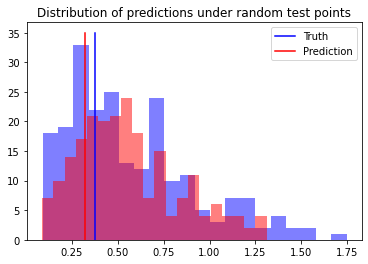

In [328]:
# Obtain predictions via GP without using a mean field fit
y_test_preds = gpr_pred_vanilla(X_train, y_train, X_test, nu=0.5, mean_zero=True)
y_true_pred = gpr_pred_vanilla(X_train, y_train, true_data, nu=0.5, mean_zero=True)

plt.hist(y_train, bins=20, alpha=0.5, label='Training', color='b')
plt.hist(y_test_preds, bins=20, alpha=0.5, label='Predictions', color='r')

plt1, = plt.plot([true_parameter, true_parameter], [0, 35], label='Truth', color='b')
plt2, = plt.plot([y_true_pred, y_true_pred], [0, 35], label='Prediction', color='r')
plt.legend(handles=[plt1, plt2], loc='upper right')

plt.title('Distribution of predictions under random test points')
plt.show()

Now we compare this to the predictions obtained from a GP after first subtracting a mean field from the data and then adding it afterward. As we can see, the predictions are often overestimating the training values of the response. This is possibly due to having a very poor mean fit -- the linear model may be extremely biased by a small dataset and a large number of parameters.

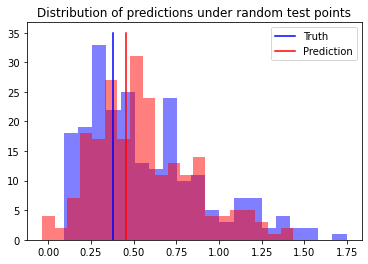

In [329]:
# Obtain predictions via GP using a mean field fit
y_test_preds = gpr_pred_vanilla(X_train, y_train, X_test, nu=0.5)
y_true_pred = gpr_pred_vanilla(X_train, y_train, true_data, nu=0.5)

plt.hist(y_train, bins=20, alpha=0.5, label='Training', color='b')
plt.hist(y_test_preds, bins=20, alpha=0.5, label='Predictions', color='r')

plt1, = plt.plot([true_parameter, true_parameter], [0, 35], label='Truth', color='b')
plt2, = plt.plot([y_true_pred, y_true_pred], [0, 35], label='Prediction', color='r')
plt.legend(handles=[plt1, plt2], loc='upper right')

plt.title('Distribution of predictions under random test points')
plt.show()

### Inspecting and testing

In [461]:
def look_at_predictions(df,
                        inputs=interesting_inputs,
                        output="soluble_accumulation_mode",
                        truth="080",
                        nu=0.5,
                        mean_zero=False):
    """
    For the supplied output, obtain both a histogram of the training responses and a histogram of the predicted responses
    from the GP regressor on new data for comparison

    Parameters

    df : Pandas DataFrame
        full data set
    inputs : list
        parameters considered from the dataset for fitting the GP
    output : str
        output of interest
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5
    mean_zero : logical
        if False, fit a mean field using linear regression, center the training response, and add back the mean after
        predicting
    """

    # "True" parameter
    true_parameter = df[(df.member == truth)][output].tolist()[0]
    true_data = df[(df.member == truth)][inputs]

    # Our data (excluding the truth)
    our_data = df[(df.member != truth)]

    # Training / testing data
    X_train = np.array(our_data[inputs])
    y_train = np.array(our_data[output])
    X_test = make_test_data(X_train)

    # Fit the emulator and obtain predictions
    y_predictions = gpr_pred_vanilla(X_train, y_train, X_test, nu, mean_zero)
    y_true_pred = gpr_pred_vanilla(X_train, y_train, true_data, nu, mean_zero)

    # Make histograms
    plt.hist(y_train, bins=20, alpha=0.5, label='Training', color='b')
    plt.hist(y_predictions, bins=20, alpha=0.5, label='Predictions', color='r')

    plt1, = plt.plot([true_parameter, true_parameter], [0, 35], label='Truth', color='b')
    plt2, = plt.plot([y_true_pred, y_true_pred], [0, 35], label='Prediction', color='r')
    plt.legend(handles=[plt1, plt2], loc='upper right')

    plt.title('Distribution of predictions of ' + output)
    plt.show()

    return


def cv_error_vanilla(df,
                     folds=10,
                     inputs=interesting_inputs,
                     output="soluble_accumulation_mode",
                     nu=0.5,
                     mean_zero=False):
    """
    Estimate the cross-validation error of a model

    Parameters

    df : Pandas DataFrame
        full data set
    folds : integer
        number of folds for cross-validation
    inputs : list
        parameters considered from the dataset for fitting the GP
    output : str
        output of interest
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5
    mean_zero : logical
        if False, fit a mean field using linear regression, center the training response, and add back the mean after
        predicting
    """

    # To record the test error on each fold...
    cv_error = []

    # Assign folds to the samples
    df["fold"] = [x % folds for x in random.sample(range(df.shape[0]), df.shape[0])]

    # Set aside data
    X = np.array(df[inputs])
    y = np.array(df[output])

    for fold in range(folds):

        # Train / test split
        X_train = np.array(df[(df.fold != fold)][inputs])
        y_train = np.array(df[(df.fold != fold)][output])
        X_test = np.array(df[(df.fold == fold)][inputs])
        y_test = np.array(df[(df.fold == fold)][output])

        # Obtain predictions
        y_predictions = gpr_pred_vanilla(X_train, y_train, X_test, nu, mean_zero)

        # Compute and record error
        cv_error.append(np.mean((y_predictions - y_test) ** 2))

    return(cv_error)


def ard_vanilla(fitted_gpr,
                threshold=10,
                parameter_names=interesting_inputs):
    """
    For automatic relevance determination. Obtain the fitted length scale parameters for the fitted_gpr object

    Parameters

    fitted_gpr : Scikit-learn GaussianProcessRegressor
        a fitted GP
    threshold : numeric
        cut-off point for what we consider an acceptably small length scale for the inclusion of a variable
    inputs : list
        parameters considered from the dataset for fitting the GP

    Value

    list
        parameters' length scales after fitting
    list
        list of parameters whose length scales are less than threshold
    """

    # To record the inputs' predictive relevances R_j...
    dtype = [('input', 'U35'), ('length_scale', float)]
    length_scales_and_names = []

    # Obtain the length scales from the 'fitted_gpr' parameter GP
    variable_length_scales = fitted_gpr.kernel_.get_params()['length_scale']

    # To produce a dictionary of parameters and their length scales...
    variable_names = np.array(parameter_names)

    for var in range(len(variable_names)):
        length_scales_and_names.append((variable_names[var], variable_length_scales[var]))

    scored_inputs = np.array(length_scales_and_names, dtype=dtype)

    return(np.sort(scored_inputs, order='length_scale'))


def mvn_kl_divergence(y_mean_unshifted_input,
                      y_std_unshifted_input,
                      y_mean_shifted_input,
                      y_std_shifted_input):
    """
    Supposing P : y_1 ~ N(mu_1, Sigma_1), Q : y_2 ~ N(mu_2, Sigma_2), where y_1, y_2 are n dimensional, it is known that

        KL(P || Q) = (1 / 2) [(mu_2 - mu_1)^T Sigma_2^{-1} (mu_2 - mu_1) + tr(Sigma_2^{-1} Sigma_1)
                        - log(det(Sigma_1) / det(Sigma_2)) - n].

    For example, reference https://statproofbook.github.io/P/mvn-kl.html. Given a vector of samples from the posterior
    prediction distributions of the shifted input space and the unshifted input space, compute the empirical KL
    divergence and return it.

    Parameters

    y_mean_unshifted_input, y_mean_shifted_input : list
        mean vectors for the posterior distributions
    y_std_unshifted_input, y_std_shifted_input : list
        vectors for the standard deviations of the samples from the posterior distributions

    Value

    numeric
        empirical KL divergence for the specified multivariate normal distributions
    """

    # mu_2 - mu_1
    mean_diff = y_mean_unshifted_input - y_mean_shifted_input

    # Sigma_2^{-1}
    sigma_2_inv = np.linalg.inv(y_std_shifted_input)

    # (mu_2 - mu_1)^T Sigma_2^{-1} (mu_2 - mu_1)
    term_1 = np.matmul(np.matrix.transpose(mean_diff), np.matmul(sigma_2_inv, mean_diff))

    # tr(Sigma_2^{-1} Sigma_1)
    term_2 = np.matrix.trace(np.matmul(sigma_2_inv, y_std_unshifted_input))

    # log(det(Sigma_1) / det(Sigma_2))
    term_3 = math.log(np.linalg.det(y_std_unshifted_input) / np.linalg.det(y_std_shifted_input))

    # d
    n = len(y_mean_unshifted_input)

    return(term_1 + term_2 - term_3 - n)


def sensitivity_analysis_vanilla(df,
                                 shift=10 ** (-4),
                                 inputs=interesting_inputs,
                                 output="soluble_accumulation_mode",
                                 nu=0.5,
                                 mean_zero=True,
                                 shift_resize=10):
    """
    For each input, compute the KL divergence in posterior prediction distributions between the basic model and that
    obtained by perturbing that input and return the ordered list of inputs with their predictive relevances R_j, where

        R_j = (1 / shift) KL[ p(y | X) || p(y | X + sum_{i=1}^d shift e_i e_j^T) ],

    where the columns of X are normalized.
    """

    # To record the inputs' predictive relevances R_j...
    dtype = [('input', 'U35'), ('relevancy', float)]
    predictive_relevances = []

    # Take the dataframe df and normalize the columns
    df_normalized = pd.DataFrame()

    for column in range(df.shape[1]):

        my_column = pd.DataFrame(df.iloc[:, column])
        
        if (column <= 3) or (column >= 70):
            df_normalized = pd.concat([df_normalized, my_column], axis=1)
        elif np.std(np.array(my_column)) == 0:
            df_normalized = pd.concat([df_normalized, my_column], axis=1)
        else:
            my_normalized_col = (1/np.std(my_column)) * (my_column - np.mean(my_column))
            df_normalized = pd.concat([df_normalized, pd.DataFrame(my_normalized_col)], axis=1)

    # Train / test split
    X_train = np.array(df_normalized[inputs])
    y_train = np.array(df_normalized[output])
    X_test = make_test_data(X_train)

    my_gpr = gpr_fit_vanilla(X_train, y_train, mean_fit_vanilla(X_train, y_train), nu)
    y_mean_unshifted_input, y_std_unshifted_input = my_gpr.predict(X_test, return_cov=True)

    # Compute predictive relevances
    for my_input in inputs:
        # shift input vector alone by vector D=(d)_{i=1}^n
        # make predictions at test data at shifted input and normal input
        # from mean and std, obtain two multivariate gaussian distributions
        # compute KL divergence between distributions, and report KL / d*sqrt(n)? this is the relevance of the input vector

        shifted_data = df_normalized
        shifted_data[my_input] += shift

        X_train = np.array(shifted_data[inputs])
        y_train = np.array(shifted_data[output])
        X_test = make_test_data(X_train)

        my_gpr = gpr_fit_vanilla(X_train, y_train, mean_fit_vanilla(X_train, y_train), nu)

        y_mean_shifted_input, y_std_shifted_input = my_gpr.predict(X_test, return_cov=True)

        predictive_relevances.append((my_input,
                                      mvn_kl_divergence(y_mean_unshifted_input, y_std_unshifted_input,
                                                        y_mean_shifted_input, y_std_shifted_input)))

    scored_inputs = np.array(predictive_relevances, dtype=dtype)

    return(np.sort(scored_inputs, order='relevancy')[::-1])

#### Examples of inspecting and testing

For variable selection, we normalize the columns of our data set.

In [257]:
df = aug_26

df_normalized = pd.DataFrame()

for column in range(df.shape[1]):
    my_column = pd.DataFrame(df.iloc[:, column])
    
    if (column <= 10) or (column >= 70):
        df_normalized = pd.concat([df_normalized, my_column], axis=1)
    elif np.std(np.array(my_column)) == 0:
        df_normalized = pd.concat([df_normalized, my_column], axis=1)
    else:
        my_normalized_col = (1/np.std(my_column)) * (my_column - np.mean(my_column))
        df_normalized = pd.concat([df_normalized, pd.DataFrame(my_normalized_col)], axis=1)

We split the data, training and testing, and set one point as the "truth."

In [258]:
# "True" parameter
true_parameter = df_normalized[(df_normalized.member == "080")][output].tolist()[0]

# "True" inputs
true_data = df_normalized[(df_normalized.member == "080")][inputs]

# Our data
our_data = df_normalized[(df_normalized.member != "080")]

# Split the data
X_train = np.array(our_data[inputs])
y_train = np.array(our_data[output])
X_test = make_test_data(X_train)

Consider the following fitted models.

In [378]:
my_fitted_model_mean_zero = gpr_fit_vanilla(X_train, y_train, mean_fit_vanilla(X_train, np.zeros(len(y_train))))
my_fitted_model_mean_nonzero = gpr_fit_vanilla(X_train, y_train, mean_fit_vanilla(X_train, y_train))

These models give similar predictions. The histograms below compare the predicted values for each model

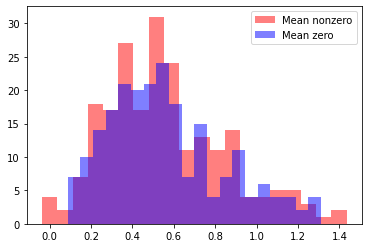

In [382]:
y_predictions_mean_zero = my_fitted_model_mean_zero.predict(X_test)

my_mean_fit = mean_fit_vanilla(X_train, y_train)
y_predictions_mean_nonzero = my_fitted_model_mean_nonzero.predict(X_test) + my_mean_fit.predict(X_test)

plt.hist(y_predictions_mean_nonzero, bins=20, alpha=0.5, label='Mean nonzero', color='r')
plt.hist(y_predictions_mean_zero, bins=20, alpha=0.5, label='Mean zero', color='b')

plt.legend(loc='upper right')

plt.show()

However, note that one aspect of the predictions of the nonzero mean model are the mean predictions (while the GP is only fitted on the residuals of the linear model).

#### Automatic relevance determination

Here are the length scales for the former model, with no mean field fit. We see that some of the variables are considered important while others are less important.

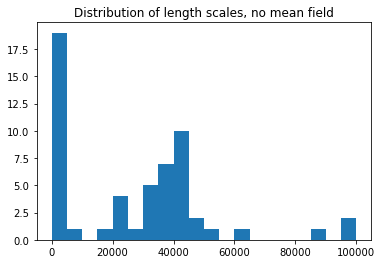

In [412]:
length_scales_mean_zero = ard_vanilla(my_fitted_model_mean_zero)

plt.hist(length_scales_mean_zero['length_scale'], bins=20, alpha=1)
plt.title('Distribution of length scales, no mean field')

plt.show()

Here are the length scales for the latter model.

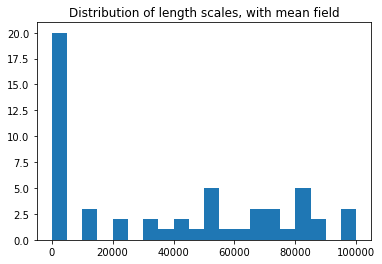

In [403]:
length_scales_mean_nonzero = ard_vanilla(my_fitted_model_mean_nonzero)

plt.hist(length_scales_mean_nonzero['length_scale'], bins=20, alpha=1)
plt.title('Distribution of length scales, with mean field')

plt.show()

We compare the ordering of variables according to the ARD for the different models in the following table, the mean not zero listed first and the mean zero listed second. The first few variables listed do not differ by much in order or length scale, but the total order is quite different.

In [429]:
all_ard = pd.concat([pd.DataFrame(length_scales_mean_nonzero), pd.DataFrame(length_scales_mean_zero)], axis=1)
all_ard.columns = ["linear mean", "length scale", "zero mean", "length scale"]
all_ard

,linear mean,length scale,zero mean,length scale
0,acure_bvoc_soa,19.654519,acure_bvoc_soa,16.079566
1,acure_dry_dep_acc,38.698285,acure_dry_dep_acc,28.775887
2,acure_kappa_oc,55.625701,acure_kappa_oc,41.740830
3,acure_convective_plume_scavenging,70.763704,acure_convective_plume_scavenging,77.386751
4,acure_carb_bb_ems_saf,75.712702,acure_carb_bb_diam,105.417933
5,acure_autoconv_exp_lwp,99.800130,acure_prim_so4_diam,108.676572
6,acure_prim_so4_diam,131.892721,m_ci,120.126314
7,acure_oxidants_o3,148.421014,acure_carb_bb_ems_naf,131.897138
8,acure_dry_dep_ait,167.151104,acure_dry_dep_ait,135.565653
9,acure_sea_spray,215.160088,acure_carb_ff_diam,151.896760


The following plots give some sense of how our predictions on new data relate to a fixed point in the parameter space. The histogram is of predictions from non-truth ensemble members on new test points. The vertical line is the true parameter. Note that the test points are agnostic of the true parameter values, so they simply reveal an approximate predictive distribution from over the entire parameter space. If the true parameters are not average in some sense, then we should not expect them to look average among the predictions.

First we consider those without the mean field fit. We see the histograms matching up quite closely for soluble accumulation mode and insoluble aitken mode, but not so for the other outputs.

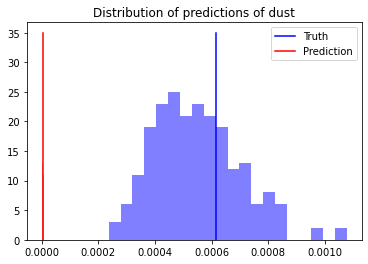

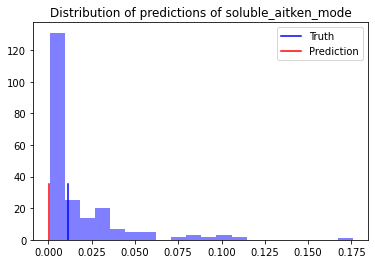

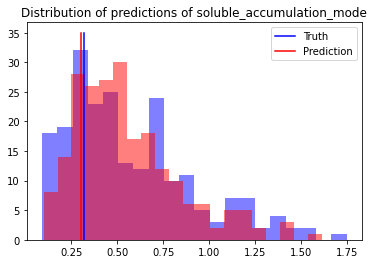

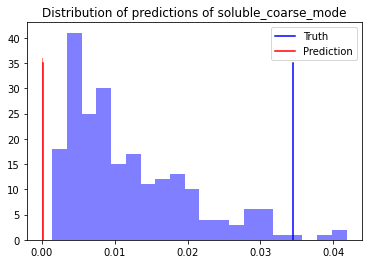

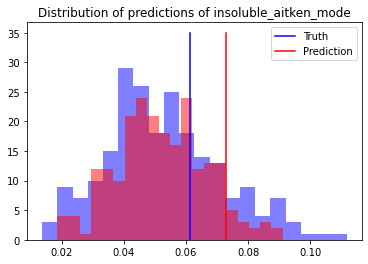

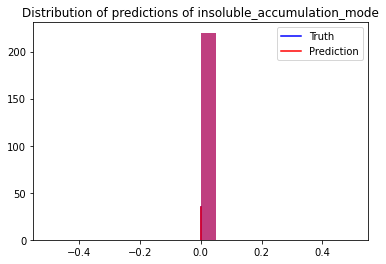

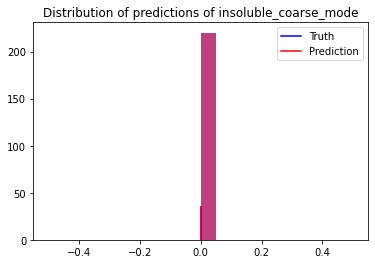

In [282]:
for output_param in variable_names.keys():
    look_at_predictions(df_normalized, output=output_param, truth="200", mean_zero=True)

Now fitting the mean field, we reasonably well calibrated predictions for all of the outputs.

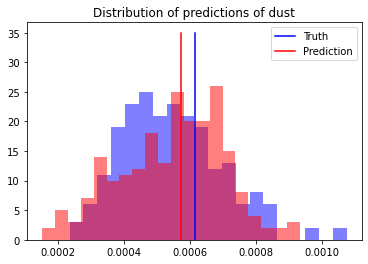

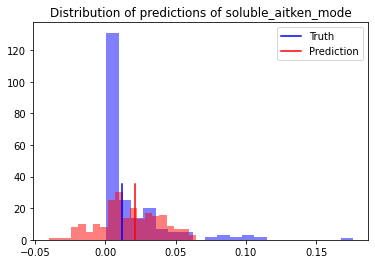

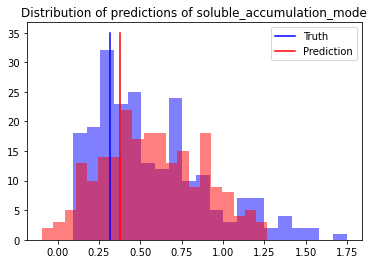

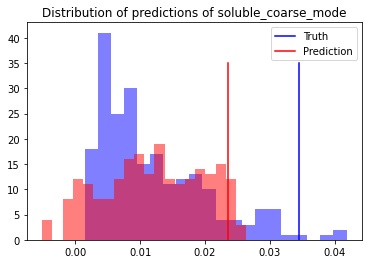

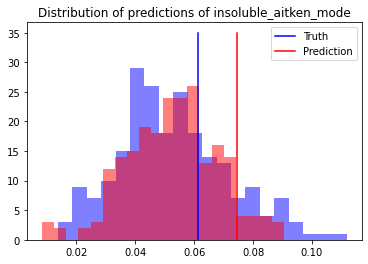

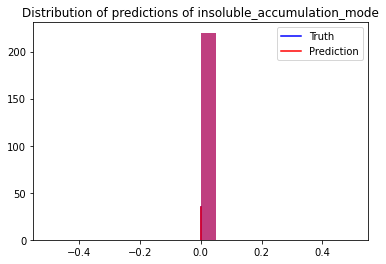

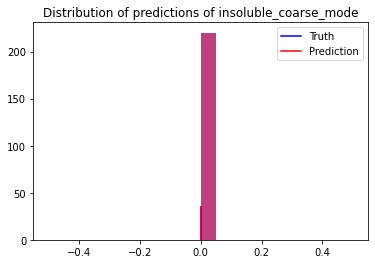

In [276]:
for output_param in variable_names.keys():
    look_at_predictions(df_normalized, output=output_param, truth="200")

Given an order on the inputs' importance according to ARD, we decide to compute the CV error for the GP fitted with the top N variables for N=1,....

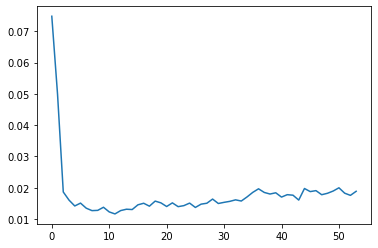

In [442]:
my_cv_errors = []
my_cv_stds = []

for num_vars in range(len(length_scales_mean_nonzero["input"])):

    if num_vars > 0:
        cv_errors_mean_nonzero_ard = cv_error_vanilla(aug_26,
                                                      folds = 10,
                                                      inputs=length_scales_mean_nonzero["input"][0:num_vars])
        my_cv_errors.append(np.mean(cv_errors_mean_nonzero_ard))
        my_cv_stds.append(np.std(cv_errors_mean_nonzero_ard))

In [1]:
length_scales_mean_nonzero["input"]

NameError: name 'length_scales_mean_nonzero' is not defined

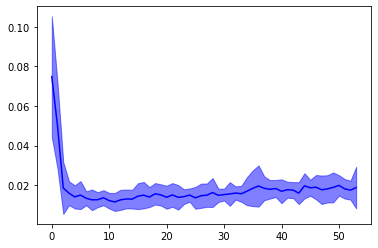

In [443]:
plt.plot(list(range(len(my_cv_errors))), my_cv_errors, color='b')


plt.fill_between(list(range(len(my_cv_errors))),
                 np.array(my_cv_errors) - np.array(my_cv_stds),
                 np.array(my_cv_errors) + np.array(my_cv_stds), alpha=0.5, color='b')

plt.show()

The plot shows that the top 6 variables or so are sufficient to obtain as good a CV error rate as any more variables will.

Now we obtain predictions for the 6 most important inputs. Whether a mean field is used for fitting does not appear to matter much.

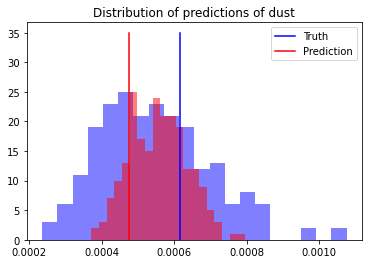

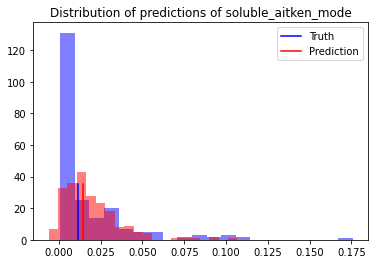

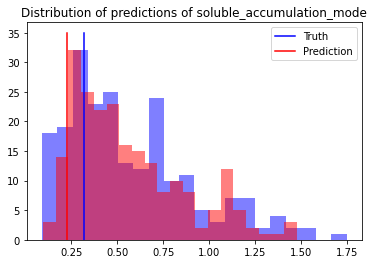

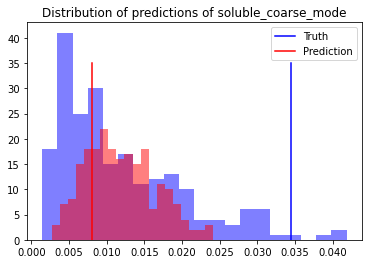

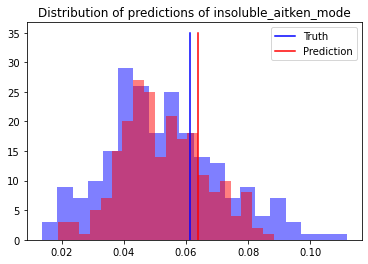

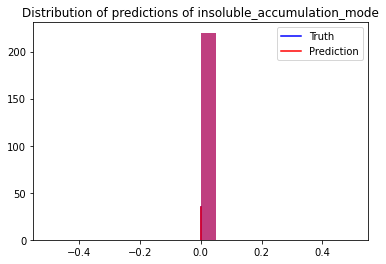

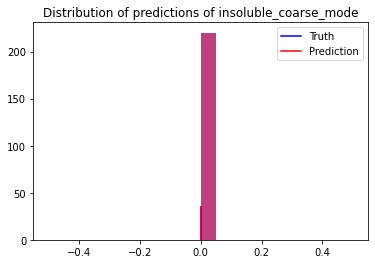

In [447]:
my_most_important_inputs = length_scales_mean_zero["input"][0:6]

for output_param in variable_names.keys():
    look_at_predictions(aug_26, inputs=my_most_important_inputs, output=output_param, truth="200", mean_zero=True)

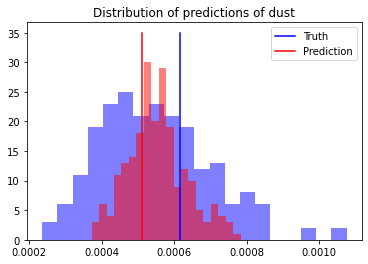

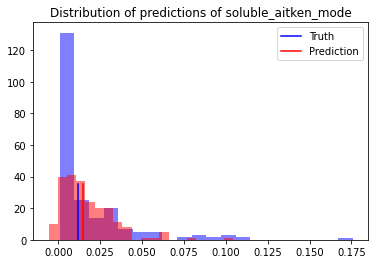

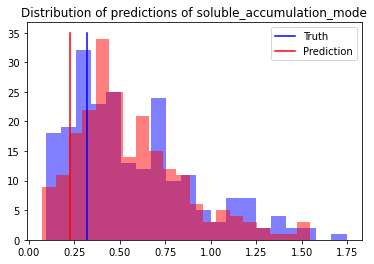

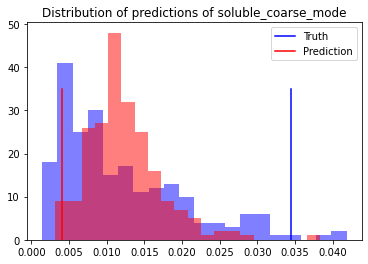

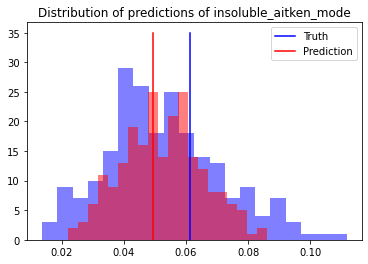

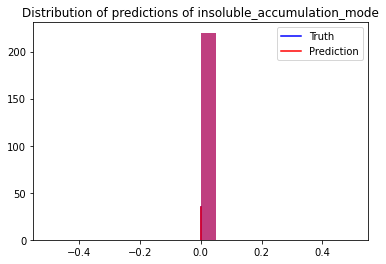

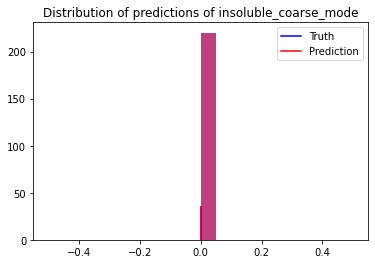

In [448]:
my_most_important_inputs = length_scales_mean_nonzero["input"][0:6]

for output_param in variable_names.keys():
    look_at_predictions(aug_26, inputs=my_most_important_inputs, output=output_param, truth="200")

#### Sensitivity analysis

Now we try using sensitivity analysis to select variables. The following procedure is described in the 'sensitivity_analysis_vanilla' method description.

In [313]:
sensitivity_results = sensitivity_analysis_vanilla(aug_26, inputs=inputs)

We compare the results of the sensitivity analysis with the results of ARD, noting that the order of the variables' importances are somewhat different between the two analyses.

In [462]:
all_ard = pd.concat([pd.DataFrame(length_scales_mean_nonzero), pd.DataFrame(sensitivity_results)], axis=1)
all_ard.columns = ["ARD", "length scale", "SA", "predictive relevances"]
all_ard

,ARD,length scale,SA,predictive relevances
0,acure_bvoc_soa,19.654519,acure_carb_bb_diam,399.333724
1,acure_dry_dep_acc,38.698285,acure_carb_res_diam,362.038313
2,acure_kappa_oc,55.625701,acure_anth_so2_eur,357.817657
3,acure_convective_plume_scavenging,70.763704,acure_carb_res_ems_lat,356.429943
4,acure_carb_bb_ems_saf,75.712702,acure_autoconv_exp_nd,352.124674
5,acure_autoconv_exp_lwp,99.800130,acure_carb_res_ems_afr,351.126223
6,acure_prim_so4_diam,131.892721,m_ci,349.711183
7,acure_oxidants_o3,148.421014,acure_bl_nuc,349.194026
8,acure_dry_dep_ait,167.151104,acure_carb_ff_ems_chi,347.346883
9,acure_sea_spray,215.160088,acure_bc_ri,345.652376


Now we compute the CV error for the GP fit on the first K inputs and plot this error as a function of K. 

In [470]:
my_sensitive_variables = sensitivity_results['input'][::-1]

my_cv_errors = []
my_cv_stds = []

for num_vars in range(len(my_sensitive_variables)):
#for num_vars in range(10):

    if num_vars > 0:
        cv_errors_mean_nonzero_sens = cv_error_vanilla(aug_26,
                                                      folds = 10,
                                                      inputs=my_sensitive_variables[0:num_vars])
        my_cv_errors.append(np.mean(cv_errors_mean_nonzero_sens))
        my_cv_stds.append(np.std(cv_errors_mean_nonzero_sens))

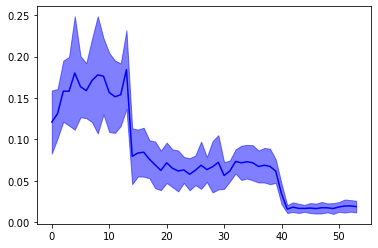

In [471]:
plt.plot(list(range(len(my_cv_errors))), my_cv_errors, color='b')


plt.fill_between(list(range(len(my_cv_errors))),
                 np.array(my_cv_errors) - np.array(my_cv_stds),
                 np.array(my_cv_errors) + np.array(my_cv_stds), alpha=0.5, color='b')

plt.show()

Looking at predictions, we see that upon the restriction of prediction to this subset of inputs our predictions no longer visually differ in distribution whether we fit a mean field or not.

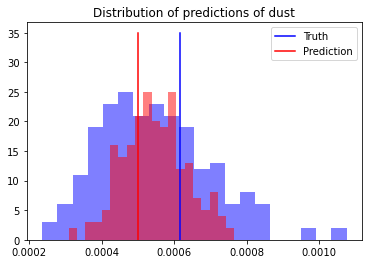

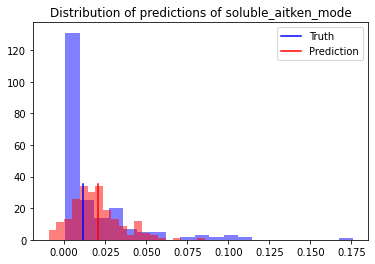

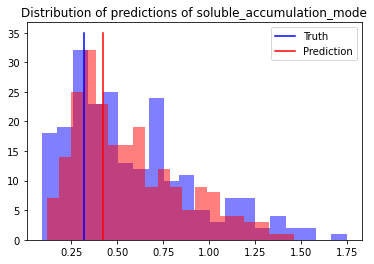

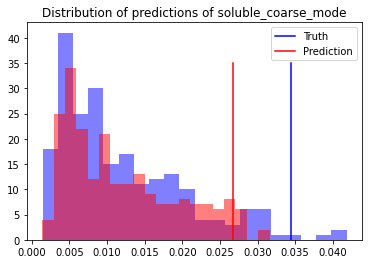

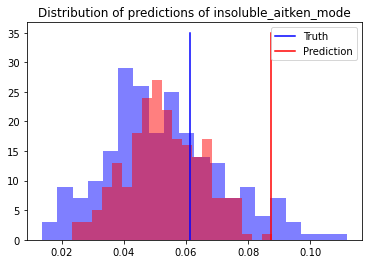

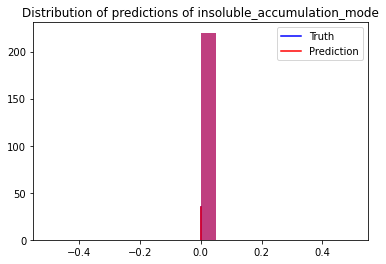

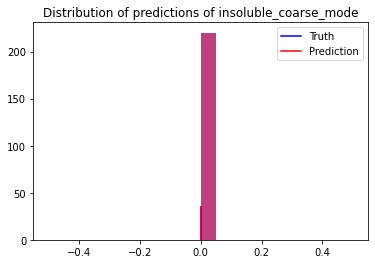

In [316]:
my_most_sensitive_variables = my_sensitive_variables[0:6]

for output_param in variable_names.keys():
    look_at_predictions(aug_26, inputs=my_most_sensitive_inputs, output=output_param, truth="200")

Interestingly, the "most sensitive" list and the "most important" list differ quite a lot, and yet they both achieve similar CV error. This must be explained by some redundancy between members of the different lists. The sensitivity analysis does not obviously depend on the scale of the input being studied at a time, but the length scale does obviously depend on the scale of the input.

In [317]:
print(set(my_most_sensitive_inputs).intersection(set(my_most_important_inputs)))
print(set(my_most_sensitive_inputs).difference(set(my_most_important_inputs)))
print(set(my_most_important_inputs).difference(set(my_most_sensitive_inputs)))

{'acure_carb_bb_ems_bnh', 'acure_dry_dep_ait', 'ai', 'acure_anth_so2_chi', 'acure_carb_ff_ems_r', 'acure_bvoc_soa', 'a_ent_1_rp', 'acure_carb_res_ems_asi', 'acure_sea_spray', 'acure_anth_so2_nam', 'acure_kappa_oc'}
{'acure_carb_ff_ems_eur', 'acure_autoconv_exp_lwp', 'acure_scav_diam', 'acure_carb_bb_ems_naf', 'acure_prim_moc', 'acure_carb_res_ems_afr', 'acure_carb_bb_ems_saf', 'two_d_fsd_factor', 'acure_carb_ff_ems_mar', 'acure_dms', 'acure_oxidants_oh'}
{'acure_carb_ff_ems_chi', 'acure_carb_ff_ems_asi', 'c_r_correl', 'acure_bc_ri', 'm_ci', 'acure_sig_w', 'acure_carb_bb_ems_rnh', 'bparam', 'acure_rain_frac', 'acure_oxidants_o3', 'acure_carb_res_ems_lat'}


#### Linear fit versus GP

In [476]:
def cv_error_linear_vanilla(df,
                     folds=10,
                     inputs=interesting_inputs,
                     output="soluble_accumulation_mode",
                     nu=0.5,
                     mean_zero=False):
    """
    Estimate the cross-validation error of a model

    Parameters

    df : Pandas DataFrame
        full data set
    folds : integer
        number of folds for cross-validation
    inputs : list
        parameters considered from the dataset for fitting the GP
    output : str
        output of interest
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5
    mean_zero : logical
        if False, fit a mean field using linear regression, center the training response, and add back the mean after
        predicting
    """

    # To record the test error on each fold...
    cv_error = []

    # Assign folds to the samples
    df["fold"] = [x % folds for x in random.sample(range(df.shape[0]), df.shape[0])]

    # Set aside data
    X = np.array(df[inputs])
    y = np.array(df[output])

    for fold in range(folds):

        # Train / test split
        X_train = np.array(df[(df.fold != fold)][inputs])
        y_train = np.array(df[(df.fold != fold)][output])
        X_test = np.array(df[(df.fold == fold)][inputs])
        y_test = np.array(df[(df.fold == fold)][output])
        
        my_linear_predictor = mean_fit_vanilla(X_train, y_train)

        # Obtain predictions
        y_predictions = my_linear_predictor.predict(X_test)

        # Compute and record error
        cv_error.append(np.mean((y_predictions - y_test) ** 2))

    return(cv_error)

In [478]:
cv_lin_error = cv_error_linear_vanilla(aug_26,
                 folds=10,
                 inputs=inputs,
                 output="soluble_accumulation_mode")

print(np.mean(cv_lin_error), np.std(cv_lin_error))

0.029974861531182524 0.013009818623739927


## GP methods using C3

In [336]:
def train_test_c3(X, y):

    # Perform training-testing split
    datasets = train_test_split(X, y, test_size=0.1)

    # Cast datasets into c3 Datasets
    X_train = c3.Dataset.fromPython(datasets[0])
    X_test = c3.Dataset.fromPython(datasets[1])
    y_train = c3.Dataset.fromPython(datasets[2])
    y_test = c3.Dataset.fromPython(datasets[3])

    return(X_train, X_test, y_train, y_test)


def gpr_fit_c3(X_train, y_train):
    """
    Parameters

    df : Pandas DataFrame
    
    """

    # Create kernel
    GPR_kernel = c3.SklearnGPRKernelMatern(lengthScale=1.0, nu=0.5).build().kernel

    # Define technique
    GPReg_technique = c3.GaussianProcessRegressionTechnique(
                        randomState=42,
                        kernel = GPR_kernel
                    )

    # Create pipe
    GPReg_pipe = c3.GaussianProcessRegressionPipe(technique=GPReg_technique)

    # Train it
    trained_GPReg_pipe = GPReg_pipe.train(input=X_train, targetOutput=y_train)

    return(trained_GPReg_pipe)


def gpr_pred_c3(gpr_fit, X_test):

    # Obtain predictions
    y_test_preds = gpr_fit.process(input=X_test)
    return(c3.Dataset.toPandas(dataset=y_test_preds))


def gpr_cv_c3(df, folds=2, inputs=list(dfparams_of_interest.columns[0:59]), output="soluble_accumulation_mode"):

    # Assign fold labels to each row
    if folds == 2:
        # Select the columns of df corresponding to inputs and outputs
        X = np.array(df[inputs])
        y = np.array(df[output])

        X_train, X_test, y_train, y_test = train_test(X, y)

        trained_GPReg_pipe = gpr_fit(X_train, y_train)

        # Obtain predictions
        y_test_preds = trained_GPReg_pipe.process(input=X_test)
        return(c3.Dataset.toPandas(dataset=y_test_preds))

    else:
        MSE = []

        fold_assignments = [x % folds for x in random.sample(range(df.shape[0]), df.shape[0])]

        df["fold"] = fold_assignments
        X = np.array(df[inputs])
        y = np.array(df[output])
        
        for fold in range(folds):

            X_train = np.array(df[(df.fold != fold)][inputs])
            y_train = np.array(df[(df.fold != fold)][output])
            X_test = np.array(df[(df.fold == fold)][inputs])
            y_test = np.array(df[(df.fold == fold)][output])

            # Cast datasets into c3 Datasets
            X_train = c3.Dataset.fromPython(X_train)
            X_test = c3.Dataset.fromPython(X_test)
            y_train = c3.Dataset.fromPython(y_train)

            trained_GPReg_pipe = gpr_fit(X_train, y_train)
            y_test_preds = np.array(c3.Dataset.toPandas(dataset=trained_GPReg_pipe.process(input=X_test)))

            MSE.append(np.mean((y_test_preds - y_test) ** 2))

        return(MSE)


def look_at_predictions(output="soluble_accumulation_mode", truth="080"):

    inputs=list(dfparams_of_interest.columns[0:59])

    # "True" parameter
    true_parameter = aug_26[(aug_26.member == truth)][output].tolist()[0]

    # Our data
    our_data = aug_26[(aug_26.member != truth)]

    # Fit the emulator
    X_train = np.array(our_data[inputs])
    y_train = np.array(our_data[output])

    X_train = c3.Dataset.fromPython(X_train)
    y_train = c3.Dataset.fromPython(y_train)

    emulator = gpr_fit(X_train, y_train)



    our_inputs = our_data[inputs]

    X_test = pd.DataFrame(our_inputs.iloc[:, 0])

    X_test_shuffled = X_test.sample(frac=1)

    for column in range(our_inputs.shape[1]):
        if column > 0:
            X_test_column = pd.DataFrame(our_inputs.iloc[:, column])
            X_test_shuffled = pd.concat([X_test_shuffled, X_test_column.sample(frac=1)], axis=1)



    X_test = np.array(X_test_shuffled)
    X_test = c3.Dataset.fromPython(X_test)

    y_test_preds = np.array(c3.Dataset.toPandas(dataset=trained_GPReg_pipe.process(input=X_test)))

    _ = plt.hist(y_test_preds,
                 bins=20)
    plt.title("Distribution of predictions of " + output)
    plt.plot([true_parameter, true_parameter], [0, 35])
    plt.show()

### Examples

In [483]:
output="soluble_accumulation_mode"
inputs=list(dfparams_of_interest.columns[0:59])

# "True" parameter
true_parameter = aug_26[(aug_26.member == "080")][output].tolist()[0]

# Our data
our_data = aug_26[(aug_26.member != "080")]

# Fit the emulator
X_train = np.array(our_data[inputs])
y_train = np.array(our_data[output])

"""
X_train = c3.Dataset.fromPython(X_train)
y_train = c3.Dataset.fromPython(y_train)
"""

emulator = gpr_fit_vanilla(X_train, y_train, nu=0.5)

/home/c3/.conda/envs/py-gordon_2_0_0/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


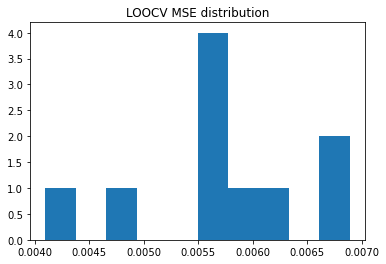

0.005720748655412906
6.231386871223982e-07


In [291]:
# gpr_0826_preds = gpr_cv(aug_26, folds=10)
# gpr_0826_preds_loocv = gpr_cv(aug_26, folds=len(ensemble))

_ = plt.hist(gpr_0826_preds,
             bins=10)
plt.title("LOOCV MSE distribution")
plt.show()

mean = np.mean(gpr_0826_preds)
print(mean)
sd = np.mean([x**2 for x in gpr_0826_preds])  - mean**2
print(sd)

We compare the distribution of predictions to the "true" parameter value and find a wide disparity.

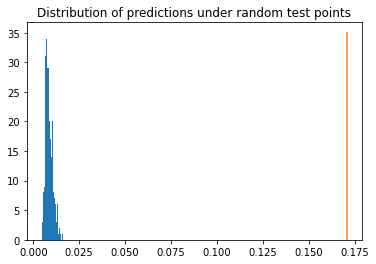

In [311]:
X_test = np.array(X_test_shuffled)
X_test = c3.Dataset.fromPython(X_test)

y_test_preds = np.array(c3.Dataset.toPandas(dataset=trained_GPReg_pipe.process(input=X_test)))

# print(y_test_preds)
_ = plt.hist(y_test_preds,
             bins=20)
plt.title("Distribution of predictions under random test points")
plt.plot([true_parameter, true_parameter], [0, 35])
plt.show()

And now do this for each output.

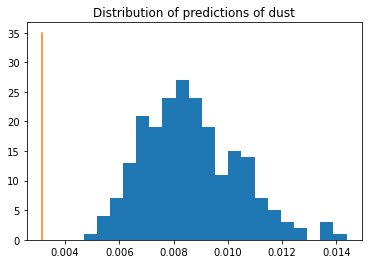

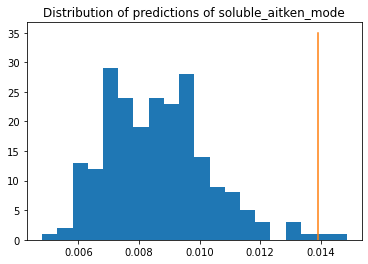

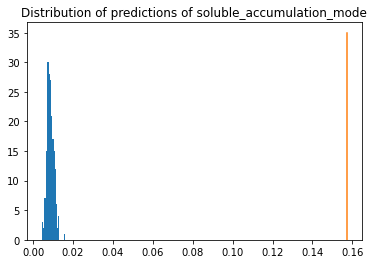

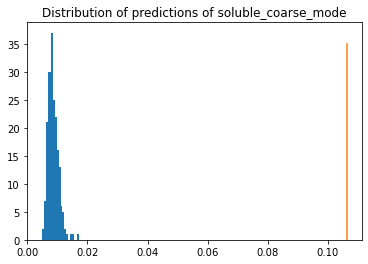

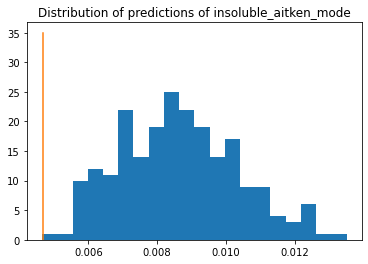

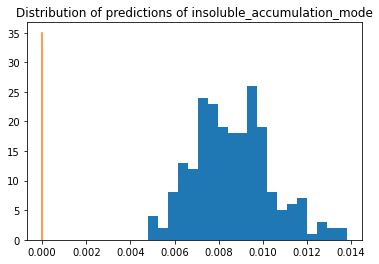

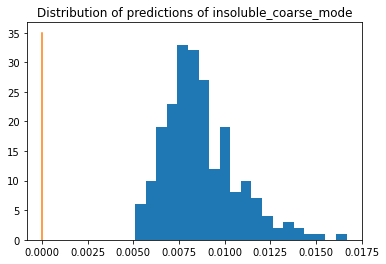

In [330]:
for output_param in variable_names.keys():
    look_at_predictions(output=output_param, truth="200")

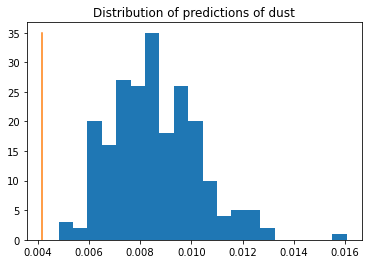

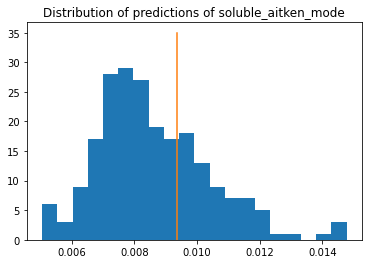

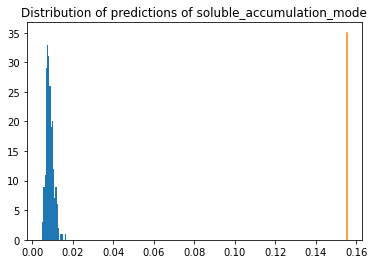

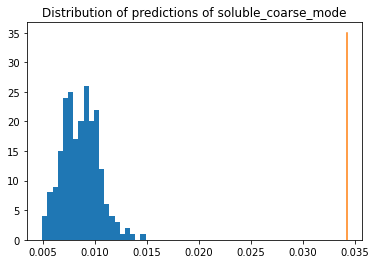

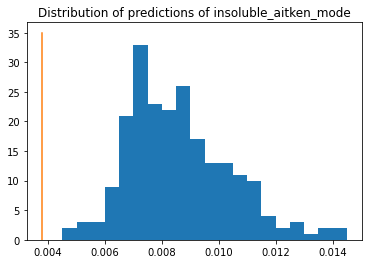

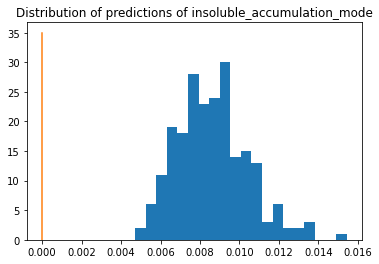

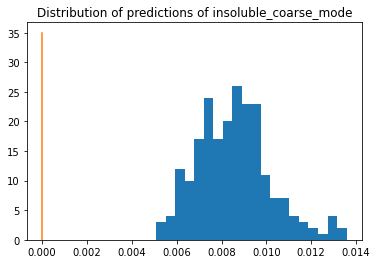

In [331]:
for output_param in variable_names.keys():
    look_at_predictions(output=output_param, truth="100")